<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>入門機械学習による異常検出</h1>
	<p>
		井出　剛著の「入門機械学習による異常検出」(以降、井出本と記す)の例題をSageを使ってお復習いします。
	</p>
</html>

<html>
	<h2>5章　不要な次元を含むデータからの異常検知</h2>
	<p>
		この章でのポイントは、主成分分析で求めた正常な空間からのずれの距離を異常度とする
		再構成誤差と思われます。
	</p>
</html>

<html>
	<h3>分散最大化による定式化</h3>
	<p>
		井出本のラグランジュ乗数の説明が私が習った方法と違うので、ここではPRMLの12章の定式化を元に
		式を整理します。
	</p>
	<p>
		PRMLの図12.2から1次元に投影されたD次元ベクトル$u_1$を使って、分散最大化による定式化の
		様子をまとめます。
		<p align="left">
			<img src="images/Figure12.2.png" width="30%"></img>
		</p>
		$u_1$は、単位ベクトルであり、$u_1^T u_1 = 1$であり、各データ点は$x_n$は、$u_1^T x_n$として投影されます。（$\tilde{x}_n$の点）
		投影されたデータの平均値は、$u_1^T \bar{x}$であり、$\bar{x}$はサンプルデータの平均です。
$$
		\bar{x} = \frac{1}{N} \sum_{n=1}^N x_n
$$		
		また、投影されたデータの分散は、以下の様に求まります。
$$
		\frac{1}{N} \sum_{n=1}^N \left \{ u_1^T x_n - u_1^T \bar{x} \right \} = u_1^T S u_1
$$		
		ここで、Sはデータの共分散行列であり、以下の様に定義されます。
$$
		S = \frac{1}{N} \sum_{n=1}^N (x_n - \bar{x})(x_n - \bar{x})^T
$$		
		投影された分散Sの最大値を求めます。ここで$u_1^T u_1 = 1$の制約が加わり、これをラグランジュ乗数を導入して、
		以下の様な式を$u_1$で微分し、０となる値を求めます。
$$
		u_1^T S u_1 + (\lambda_1 - u_1^T u_1)
$$
		以下の公式にSが対象行列であることを使うと、第1項の偏微分は以下のようになります。
$$
		\frac{\partial u_1^T S u_1}{\partial u_1} = (S + S^T)u_1 = 2 S u_1
$$		
		右辺をまとめると、
$$
\begin{eqnarray}

		0 & = & \frac{\partial}{\partial u_1} \left [ u_1^T S u_1 - \lambda_1(1 - u_1^T u_1) \right] \\
		  & = & ( 2S u_1 - 2 \lambda_1 u_1 )
\end{eqnarray}		
$$
		固有値の定義から、u_1が固有値$\lambda_1$の固有ベクトルであることが分かります。
$$
		S u_1 = \lambda_1 u_1
$$	
		上記の式に左から$u_1^T$を掛け、$u_1^T u_1 = 1 $から、分散$\lambda_1$（固有値）は以下の様に求まります。
$$
		u_1^T S u_1 = \lambda_1
$$		
	</p>
</html>

<html>
	<h3>準備</h3>
	<p>
		いつものように必要なライブラリを読み込み、テストデータとしてRのMASSパッケージに含まれているCars93を使用します。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

In [3]:
# RのテストデータCars93をPandasのデータフレームに変換
r('library(MASS)')
cars93 = RDf2PandaDf('Cars93')

<html>
	<h3>データ選択</h3>
	<p>
		Cars93は、９３年のアメリカの車の指標と集めたもので、価格（Min.Price, Price, Max.Price）と燃費（MPG.city, MPG.highway）、
		エンジンサイズ、馬力など、１５項目を使用します。
	</p>
</html>

In [4]:
# 以下の15変数を選択し、Make（製品名）をインデックスとする
cc = ['Min.Price', 'Price', 'Max.Price', 'MPG.city', 'MPG.highway', 'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity', 'Length', 'Wheelbase', 'Width', 'Turn.circle', 'Weight', 'Make']
X = cars93[cc]
X = X.set_index(['Make'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, Acura Integra to Volvo 850
Data columns (total 15 columns):
Min.Price             93 non-null float64
Price                 93 non-null float64
Max.Price             93 non-null float64
MPG.city              93 non-null int64
MPG.highway           93 non-null int64
EngineSize            93 non-null float64
Horsepower            93 non-null int64
RPM                   93 non-null int64
Rev.per.mile          93 non-null int64
Fuel.tank.capacity    93 non-null float64
Length                93 non-null int64
Wheelbase             93 non-null int64
Width                 93 non-null int64
Turn.circle           93 non-null int64
Weight                93 non-null int64
dtypes: float64(5), int64(10)
memory usage: 11.6+ KB


<html>
	<h3>データのスケーリング</h3>
	<p>
		データを平均と分散でスケーリングし、データ個数Nをセットします。
	</p>
</html>

In [5]:
# 中心にスケーリングしたデータ
Xc = (X - X.mean())/X.std()
N = Xc.shape[0]

<html>
	<p>
		Pandasの関数で共分散行列を求めます。これとSageで定義に従って計算した共分散行列Sigの値を比較し、
		正しく計算できていることを確認しました。
	</p>
</html>

In [6]:
# Pandasで共分散行列Sigを求める
Sig = matrix(Xc.cov().values)
# show(Sig)

In [7]:
# 定義に基づきSageで散布行列Sを計算し、正規化して共分散行列Sigを表示して上記と一致することを確認
Xcm = matrix(Xc.values).T
S = Xcm*Xcm.T
Sig = S/(N-1)
# show(Sig)

<html>
	<h3>固有値と固有ベクトル</h3>
	<p>
		Sageのeigenmatrix_leftを使って散布行列Sの固有値と固有ベクトルを求めます。
	</p>
	<p>
		固有値の値を大きい順にプロットしてみます。２〜３成分程度で十分表現できることが分かります。
	</p>
</html>

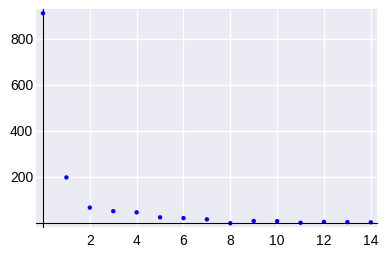

In [8]:
# 固有値Lamと固有ベクトルUを求める
(Lam, U) = S.eigenmatrix_left()
# 固有ベクトルのプロット
list_plot(Lam.diagonal(), figsize=4, zorder=2)

<html>
	<h3>第１と第２固有ベクトル</h3>
	<p>
		各点を第１と第２固有ベクトルに投影します。
	</p>
</html>

In [9]:
# 固有ベクトルの第1成分と第2成分上にプロットする
U12 = U.submatrix(0, 0, 2, 15)
Z = Xcm.T*(U12.T); Z

93 x 2 dense matrix over Real Double Field (use the '.str()' method to see the entries)

<html>
	<h3>第１と第２固有ベクトル空間での分布</h3>
	<p>
		観測値を第１と第２固有ベクトル空間での分布をプロットしてみます。井出本の分布と比べると第１成分が正負逆になって
		いますが、分布は同じように思われます。
	</p>
</html>

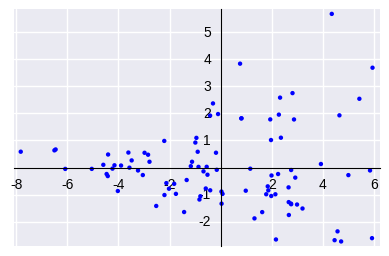

In [10]:
list_plot(Z.numpy(), figsize=4, zorder=2)

<html>
	<h2>異常値の検出</h2>
	<p>
		異常値は、主成分分析を行った固有値ベクトルに投影した値と観測値の残差と井出本では定義しています。
		これを再構成残差と呼んでいます。
$$
		a_1(x') = (x' - \hat{\mu})^T \left [ I_M -U_m U_m^T \right ] (x' -\hat{\mu})
$$		
	</p>
	<p>
		Sageでの計算では、numpyのarrayにした後、カラムの和(Rのcolsumsの代わり)を求めるため、sum(1)を使っています。
	</p>
</html>

In [11]:
# 要素毎の積を計算するためnumpyデータに変換する
xcm = Xcm.T.numpy()
x2 = (Xcm.T*(U12.T)).numpy()
# 要素の二乗を計算し、カラムの和を取り異常度a1を求める
a1 = (xcm*xcm).sum(1) - (x2*x2).sum(1)

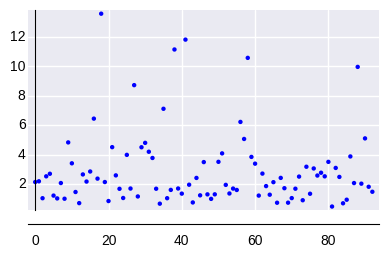

In [12]:
list_plot(a1, figsize=4, zorder=2)

<html>
	<h3>異常度の高い車種</h3>
	<p>
		異常度a1をXに追加して、異常度の高い順にソートしてトップ5を取ってみると、
		井出本の通りの結果となりました。
	</p>
</html>

In [13]:
# 異常度をXに追加
X['a1'] = a1

In [14]:
# 異常度の高い順に6個出力
cols = ['a1',  'Price', 'MPG.city', 'Horsepower', 'Length']
a5 = X.sort_values(by=['a1'], ascending=False)[cols]
a5.head()

,a1,Price,MPG.city,Horsepower,Length
Make,,,,,
Chevrolet Corvette,13.595830,38.0,17,300,179
Honda Civic,11.829742,12.1,42,102,173
Geo Metro,11.156367,8.4,46,55,151
Mercedes-Benz 300E,10.586025,61.9,19,217,187
Volkswagen Eurovan,9.971148,19.7,17,109,187


<html>
	<h2>カーネル主成分分析</h2>
	<p>
		井出本では、カーネル主成分分析の式の導出をしていますが、潜在変数の導入理由や考え方は、
		PRMLの説明の方が分かりやすいのでここでは省略します。
	</p>
	<p>
		井出本ではRのkernlabパッケージを使っていますが、ここではsklearnのKernelPCAを使って
		計算してみます。
	</p>
	<p>
		最初にsklearnのPCAを使って第１主成分と第２主成分にXcをプロットしてみます。
		結果は、先ほど求めた結果と同じになりました。
	</p>
</html>

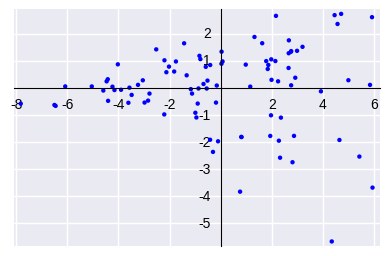

In [15]:
# sklearnのPCAを使ってみる
from sklearn.decomposition import PCA, KernelPCA
pca = PCA()
X_pca = pca.fit_transform(Xc)
list_plot(X_pca[:, 0:2], figsize=4, zorder=2)

<html>
	<h3>KernelPCAを使ってみる</h3>
	<p>
		sklearnのPCAの使い方が分かったので、今度はKernelPCAで同様の計算をしてみます。
		カーネルにはrbfを使いgamma=0.001と0.1の結果を出力してみます。
	</p>
	<p>
		今度は、井出本と同様の結果が求まりました。KernelPCAは、計算に使用する固有値が少ない場合、
		PCAよりも速く計算することができるので、データ数が多い場合には有効です。
	</p>
</html>

In [16]:
# sklearnのKernelPCAを使ってみる
# σ=0.001（通常のPCAに近い）、σ=0.1の違いをみる
kpca = KernelPCA(kernel="rbf", gamma=0.001)
X_kpca = kpca.fit_transform(Xc)
g0_001 = list_plot(X_kpca[:, 0:2], figsize=4, zorder=2)

σ=0.001,σ=0.1
,

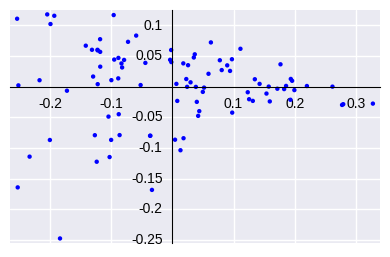
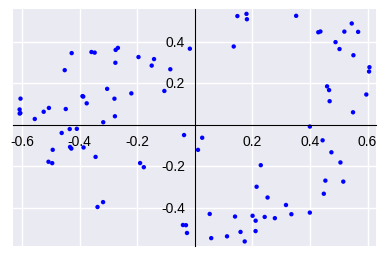

In [17]:
kpca = KernelPCA(kernel="rbf", gamma=0.1)
X_kpca = kpca.fit_transform(Xc)
g0_1 = list_plot(X_kpca[:, 0:2], figsize=4, zorder=2)
Table2Html([[_to_png(g0_001), _to_png(g0_1)]], header=['σ=0.001', 'σ=0.1'])